### setup

In [ ]:
!pip install scikit-learn==0.22.1 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sklearn-crfsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U -q PyDrive

In [ ]:
from itertools import chain
import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [ ]:
import nltk
import os
import string
from pathlib import Path
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
from nltk.corpus import PlaintextCorpusReader

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Import data

In [ ]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def download_and_save(file_name, file_id):
  downloaded = drive.CreateFile({'id': file_id})
  # fetch file
  downloaded.FetchContent()
  # write file
  with open(file_name,'wb') as f:
       f.write(downloaded.content.read())
      
  print(f'Saved {file_name}')
  
FILE_NAME, FILE_ID = ['file_name', 'file_id']

In [ ]:
corpus_root = os.getcwd() + "/"
file_ids = "nkjp-morph-named.txt"
newcorpus = PlaintextCorpusReader(corpus_root, file_ids)

#downloading file 
#https://drive.google.com/file/d/121A1wodBB0PQTKAj7N8VIpRdOU8bQM9o/view?usp=sharing
file = {FILE_NAME: 'nkjp-morph-named.txt', FILE_ID: '121A1wodBB0PQTKAj7N8VIpRdOU8bQM9o'}
dataset_path = Path('/content')
file_path = dataset_path / file[FILE_NAME]
download_and_save(file_path, file[FILE_ID])

Saved /content/nkjp-morph-named.txt


In [ ]:
filename = "nkjp-morph-named.txt"

def get_loaded_dataset(path_file):
    i=0
    dataset = []
    entry = []
    new_entry = []
    with open(path_file, encoding='utf-8', errors='replace') as f:
        for line in f:
            #print("i: "+ str(i) + " -> "+ line)
            line_split = line.split()
            if not entry and line_split[0] == ".":
                continue
            tmp = (line_split[0], line_split[-2], line_split[-1])
            entry.append(tmp)
            if line_split[0] == ".":
                new_entry = entry
                dataset.append(new_entry)
                entry = []
            i=i+1
    return dataset

## Named-entity recognition system

CoNLL2002 corpus is available in NLTK


In [ ]:
content= get_loaded_dataset(os.path.abspath(filename))

train_sents = content[:15000]
test_sents = content[15000:]

In [ ]:
print(train_sents[:100])
print(test_sents[:100])

[[('Zatrzasnął', 'praet:sg:m1:perf', 'O'), ('drzwi', 'subst:pl:acc:n', 'O'), ('od', 'prep:gen:nwok', 'O'), ('mieszkania', 'subst:sg:gen:n', 'O'), (',', 'interp', 'O'), ('dwa', 'num:pl:acc:m3:congr', 'O'), ('razy', 'subst:pl:acc:m3', 'O'), ('przekręcił', 'praet:sg:m1:perf', 'O'), ('klucz', 'subst:sg:acc:m3', 'O'), (',', 'interp', 'O'), ('nacisnął', 'praet:sg:m1:perf', 'O'), ('klamkę', 'subst:sg:acc:f', 'O'), (',', 'interp', 'O'), ('by', 'comp', 'O'), ('sprawdzić', 'inf:perf', 'O'), (',', 'interp', 'O'), ('czy', 'qub', 'O'), ('dobrze', 'adv:pos', 'O'), ('zamknięte', 'ppas:pl:nom:n:perf:aff', 'O'), (',', 'interp', 'O'), ('zbiegł', 'praet:sg:m1:perf', 'O'), ('po', 'prep:loc', 'O'), ('schodach', 'subst:pl:loc:n', 'O'), (',', 'interp', 'O'), ('minął', 'praet:sg:m1:perf', 'O'), ('furtkę', 'subst:sg:acc:f', 'O'), (',', 'interp', 'O'), ('także', 'qub', 'O'), ('ją', 'ppron3:sg:acc:f:ter:akc:npraep', 'O'), ('zamknął', 'praet:sg:m1:perf', 'O'), (',', 'interp', 'O'), ('i', 'conj', 'O'), ('znalazł',

In [ ]:
print('wielkosć zbioru treningowego:', len(train_sents))
print('wielkosć zbioru testowego:' , len(test_sents))
train_sents[10]

wielkosć zbioru treningowego: 15000
wielkosć zbioru testowego: 68781


[('To', 'pred', 'O'),
 ('są', 'fin:pl:ter:imperf', 'O'),
 ('oczywistości', 'subst:pl:nom:f', 'O'),
 ('.', 'interp', 'O')]

In [ ]:
#listing tagów w zbiorze treningowym tagi (2 kolumna) i etykiety (3 kolumna)

labl={}
tagl={}
for s in train_sents:
    for w in s:
        try:
            labl[w[2]]+=1
        except KeyError:
            labl[w[2]]=1
        try:
            tagl[w[1]]+=1
        except KeyError:
            tagl[w[1]]=1
#labl=sorted(labl)
#tagl=sorted(tagl)

In [ ]:
print(labl)
print(tagl)
print(sorted(labl))
print(sorted(tagl))

{'O': 217689, 'persName_surname': 2933, 'placeName_settlement': 1562, 'orgName': 3933, 'geogName': 1382, 'persName_addName': 179, 'persName_forename': 2757, 'persName': 411, 'time': 214, 'placeName_country': 1851, 'date': 2106, 'placeName': 77, 'placeName_region': 128, 'placeName_bloc': 28, 'placeName_district': 65}
{'praet:sg:m1:perf': 1657, 'subst:pl:acc:n': 609, 'prep:gen:nwok': 2726, 'subst:sg:gen:n': 2643, 'interp': 41319, 'num:pl:acc:m3:congr': 149, 'subst:pl:acc:m3': 1087, 'subst:sg:acc:m3': 2729, 'subst:sg:acc:f': 3079, 'comp': 3313, 'inf:perf': 2164, 'qub': 11761, 'adv:pos': 4260, 'ppas:pl:nom:n:perf:aff': 42, 'prep:loc': 3001, 'subst:pl:loc:n': 458, 'ppron3:sg:acc:f:ter:akc:npraep': 109, 'conj': 9161, 'adj:sg:loc:f:pos': 909, 'subst:sg:loc:f': 2399, 'prep:inst': 363, 'subst:pl:inst:m3': 318, 'adv': 3070, 'praet:pl:m3:imperf': 133, 'prep:loc:nwok': 5430, 'adj:sg:loc:n:pos': 348, 'subst:sg:loc:n': 1116, 'adj:pl:nom:m3:pos': 548, 'subst:pl:nom:m3': 815, 'adj:pl:gen:m3:pos': 908,

## Features

word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used. 



In [ ]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'word[:3]': word[:3],
        'word[:-3]': word[-3:],
        
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word[:3]': word1[:3],
            '-1:word[:-3]': word1[-3:],

           
        })
    else:
        features['BOS'] = True
  
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
        })
    else:
        features['EOS'] = True
    
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

This is what word2features extracts:

In [ ]:
print(train_sents[0])
sent2features(train_sents[0])[1]

[('Zatrzasnął', 'praet:sg:m1:perf', 'O'), ('drzwi', 'subst:pl:acc:n', 'O'), ('od', 'prep:gen:nwok', 'O'), ('mieszkania', 'subst:sg:gen:n', 'O'), (',', 'interp', 'O'), ('dwa', 'num:pl:acc:m3:congr', 'O'), ('razy', 'subst:pl:acc:m3', 'O'), ('przekręcił', 'praet:sg:m1:perf', 'O'), ('klucz', 'subst:sg:acc:m3', 'O'), (',', 'interp', 'O'), ('nacisnął', 'praet:sg:m1:perf', 'O'), ('klamkę', 'subst:sg:acc:f', 'O'), (',', 'interp', 'O'), ('by', 'comp', 'O'), ('sprawdzić', 'inf:perf', 'O'), (',', 'interp', 'O'), ('czy', 'qub', 'O'), ('dobrze', 'adv:pos', 'O'), ('zamknięte', 'ppas:pl:nom:n:perf:aff', 'O'), (',', 'interp', 'O'), ('zbiegł', 'praet:sg:m1:perf', 'O'), ('po', 'prep:loc', 'O'), ('schodach', 'subst:pl:loc:n', 'O'), (',', 'interp', 'O'), ('minął', 'praet:sg:m1:perf', 'O'), ('furtkę', 'subst:sg:acc:f', 'O'), (',', 'interp', 'O'), ('także', 'qub', 'O'), ('ją', 'ppron3:sg:acc:f:ter:akc:npraep', 'O'), ('zamknął', 'praet:sg:m1:perf', 'O'), (',', 'interp', 'O'), ('i', 'conj', 'O'), ('znalazł', 

{'bias': 1.0,
 'word.lower()': 'drzwi',
 'word.isupper()': False,
 'word.istitle()': False,
 'word.isdigit()': False,
 'postag': 'subst:pl:acc:n',
 'word[:3]': 'drz',
 'word[:-3]': 'zwi',
 '-1:word.lower()': 'zatrzasnął',
 '-1:word.istitle()': True,
 '-1:word[:3]': 'Zat',
 '-1:word[:-3]': 'nął',
 '+1:word.lower()': 'od',
 '+1:word.istitle()': False}

Extract features from the data:

In [ ]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 3.61 s, sys: 532 ms, total: 4.15 s
Wall time: 4.23 s


## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [ ]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 1min 9s, sys: 376 ms, total: 1min 9s
Wall time: 1min 20s


/root/.local/lib/python3.10/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [ ]:
labels = list(crf.classes_)
labels.remove('O')
labels

['persName_surname',
 'placeName_settlement',
 'orgName',
 'geogName',
 'persName_addName',
 'persName_forename',
 'persName',
 'time',
 'placeName_country',
 'date',
 'placeName',
 'placeName_region',
 'placeName_bloc',
 'placeName_district']

In [ ]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.7284123028258767

per-class results

In [ ]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

                      precision    recall  f1-score   support

                date      0.872     0.879     0.875      7502
            geogName      0.641     0.453     0.531      5329
            persName      0.883     0.539     0.670      1363
    persName_addName      0.411     0.041     0.074       955
   persName_forename      0.849     0.733     0.787     11037
    persName_surname      0.788     0.862     0.823     10814
                time      0.852     0.637     0.729      1397
           placeName      0.904     0.373     0.528       303
      placeName_bloc      0.207     0.050     0.080       121
   placeName_country      0.868     0.785     0.824      6462
  placeName_district      0.571     0.073     0.129       330
    placeName_region      0.754     0.219     0.339       909
placeName_settlement      0.793     0.601     0.684      7312
             orgName      0.763     0.632     0.691     16635

           micro avg      0.803     0.687     0.740     70469
      

## Hyperparameter Optimization

 regularization parameters using randomized search and 3-fold cross-validation.


In [ ]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100,  #20
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=10,   #zmienione 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 19.3min finished


CPU times: user 1min 52s, sys: 4.03 s, total: 1min 56s
Wall time: 20min 27s


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None, gamma=None,
                                 keep_...
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['persName_surname', 'placeName_settlement', 'orgName', 'geogName', 'persName_addName', 'persName_forename', 'per

Best result:

In [ ]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.09238258429693198, 'c2': 0.0035163810360641676}
best CV score: 0.7223338929517067
model size: 1.66M


### Check parameter space

A chart which shows which ``c1`` and ``c2`` values have RandomizedSearchCV checked. 

Dark blue => 0.6932, dark red => 0.7223


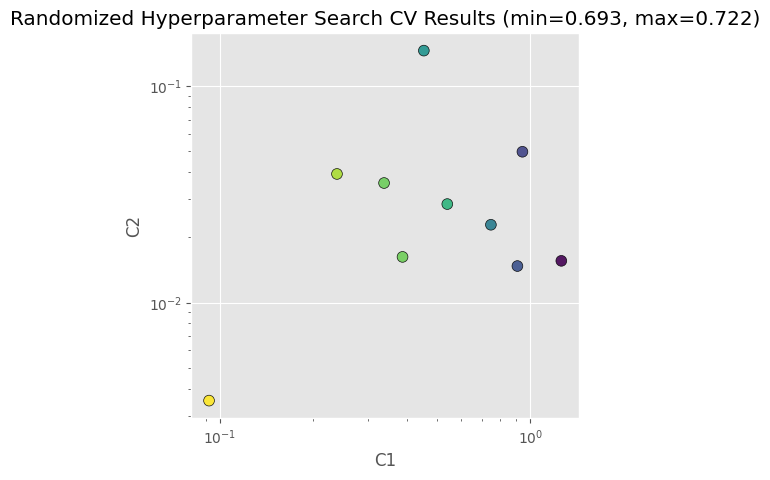

In [ ]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_test_score']]

fig = plt.figure()
fig.set_size_inches(5, 5)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Check best estimator on test data

As you can see, quality is improved.

In [ ]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

                      precision    recall  f1-score   support

                date      0.864     0.886     0.875      7502
            geogName      0.636     0.460     0.534      5329
            persName      0.846     0.557     0.672      1363
    persName_addName      0.375     0.050     0.089       955
   persName_forename      0.854     0.738     0.792     11037
    persName_surname      0.786     0.863     0.823     10814
                time      0.814     0.638     0.715      1397
           placeName      0.835     0.485     0.614       303
      placeName_bloc      0.154     0.050     0.075       121
   placeName_country      0.875     0.813     0.843      6462
  placeName_district      0.470     0.094     0.157       330
    placeName_region      0.612     0.264     0.369       909
placeName_settlement      0.787     0.612     0.688      7312
             orgName      0.771     0.624     0.690     16635

           micro avg      0.802     0.693     0.743     70469
      

## Let's check what classifier learned

In [ ]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
placeName_district -> placeName_district 4.784117
time   -> time    4.248007
O      -> O       4.064936
orgName -> orgName 3.947171
persName -> persName 3.887781
placeName_region -> placeName_region 3.795615
geogName -> geogName 3.510311
persName_addName -> persName_addName 3.412073
persName_surname -> persName_surname 3.337369
date   -> date    3.062421
persName_forename -> persName_surname 2.115746
placeName_settlement -> placeName_settlement 2.053420
placeName_bloc -> placeName_bloc 1.933556
persName_forename -> persName_forename 1.859958
placeName_region -> placeName_settlement 1.797108
placeName_country -> placeName_country 1.524579
placeName -> O       1.169837
geogName -> placeName_district 1.168042
O      -> placeName_country 1.158687
O      -> persName_forename 1.027148

Top unlikely transitions:
date   -> geogName -2.632887
persName_forename -> placeName_settlement -2.672190
placeName_country -> persName_surname -2.673359
persName_addName -> persName_s

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
12.198381 orgName  +1:word.lower():o.o
12.004595 persName_surname +1:word.lower():tse
11.420996 persName_surname +1:word.lower():ensemble
11.174601 placeName_settlement word.lower():paryskiego
11.108118 placeName word[:3]:żyd
11.104537 placeName_country word[:3]:Szw
10.640590 placeName_country word[:3]:ame
10.600354 placeName_country word[:3]:Egi
10.285740 placeName_settlement word.lower():szczeciniaków
10.061613 placeName_country word.lower():polskiego
9.918634 orgName  word[:-3]:SiR
9.794317 placeName_settlement word[:-3]:LIN
9.616724 placeName_country word[:3]:Ukr
9.607724 persName_forename word.lower():piast
9.507248 placeName_settlement word[:3]:Rig
9.403751 placeName_country word[:3]:Izr
9.383038 orgName  word.lower():chorwacja
9.126263 placeName_country word.lower():polskim
9.081010 placeName_country word[:3]:Ira
9.069911 O        +1:word.lower():lube
9.037936 geogName word.lower():małopolskiego
9.036471 placeName_settlement word[:3]:tuc
8.974657 orgName  word.lowe

In [ ]:
#krosswalidacja
from sklearn.model_selection import KFold
import numpy

A = numpy.array([[1, 2], [3, 4], [1, 2], [3, 4], [5,6],[7,8]])
b = numpy.array([1, 2, 3, 4,5,6])
kf = KFold(n_splits=3)
kf.get_n_splits(A)
print(kf)
#KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(A):
     print("TRAIN:", train_index, "TEST:", test_index)
     b_train, b_test = b[train_index], b[test_index]

KFold(n_splits=3, random_state=None, shuffle=False)
TRAIN: [2 3 4 5] TEST: [0 1]
TRAIN: [0 1 4 5] TEST: [2 3]
TRAIN: [0 1 2 3] TEST: [4 5]


In [ ]:
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
y_pred_all=[]
for train_index, test_index in kf.split(X_train):
    X_tr, X_tst = numpy.array(X_train)[train_index], numpy.array(X_train)[test_index]
    y_tr, y_tst = numpy.array(y_train)[train_index], numpy.array(y_train)[test_index]
    #print(train_index[1])
    #print(X_train[test_index[0]])
    crf.fit(X_tr, y_tr)
    y_pred = crf.predict(X_tst)
    #print("fold")
    #print(metrics.flat_classification_report(y_tst, y_pred, labels=sorted_labels, digits=3))
    y_pred_all.extend(y_pred)
print("all results")
print(metrics.flat_classification_report(y_train, y_pred_all, labels=sorted_labels, digits=3))
  
  

<ipython-input-160-bcc02f5632d2>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_tr, X_tst = numpy.array(X_train)[train_index], numpy.array(X_train)[test_index]
<ipython-input-160-bcc02f5632d2>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_tr, y_tst = numpy.array(y_train)[train_index], numpy.array(y_train)[test_index]


all results
                      precision    recall  f1-score   support

                date      0.949     0.884     0.915      2106
            geogName      0.645     0.436     0.521      1382
            persName      0.779     0.574     0.661       411
    persName_addName      0.551     0.151     0.237       179
   persName_forename      0.835     0.752     0.791      2757
    persName_surname      0.805     0.842     0.823      2933
                time      0.839     0.584     0.689       214
           placeName      0.825     0.429     0.564        77
      placeName_bloc      0.333     0.036     0.065        28
   placeName_country      0.866     0.783     0.822      1851
  placeName_district      0.167     0.015     0.028        65
    placeName_region      0.375     0.047     0.083       128
placeName_settlement      0.775     0.622     0.690      1562
             orgName      0.665     0.548     0.601      3933

           micro avg      0.791     0.682     0.732     

## Results

Budowa końcowego modelu na całych danych treningowych i testowanie na danych testowych

In [ ]:
crf.fit(X_train, y_train)
y_pred = crf.predict(X_test)
print("wynik na danych testowych")
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

wynik na danych testowych
                      precision    recall  f1-score   support

                date      0.864     0.886     0.875      7502
            geogName      0.636     0.460     0.534      5329
            persName      0.846     0.557     0.672      1363
    persName_addName      0.375     0.050     0.089       955
   persName_forename      0.854     0.738     0.792     11037
    persName_surname      0.786     0.863     0.823     10814
                time      0.814     0.638     0.715      1397
           placeName      0.835     0.485     0.614       303
      placeName_bloc      0.154     0.050     0.075       121
   placeName_country      0.875     0.813     0.843      6462
  placeName_district      0.470     0.094     0.157       330
    placeName_region      0.612     0.264     0.369       909
placeName_settlement      0.787     0.612     0.688      7312
             orgName      0.771     0.624     0.690     16635

           micro avg      0.802     0.693 